In [1]:
#! /usr/bin/env python
# encoding: utf-8
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import cluster
from scipy.cluster.vq import kmeans,vq
from time import time
import time
import datetime

import jieba
import jieba.analyse

from __future__ import print_function


import unidecode
from nltk.chunk import ne_chunk
import gensim
import logging
import codecs
import cPickle as pickle
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from collections import Counter
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from microsofttranslator import Translator

/Users/jamesevers/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load dataframes

In [2]:
###load pickled data
# ok = pd.read_csv('data/week1.csv', header=0)
weibo = pickle.load(open("verboten.p","rb"))

In [3]:
shortened = weibo[:500]

In [ ]:
# ok = ok.iloc[np.random.permutation(len(ok))][:len(forbidden)]

In [ ]:
# frames = [ok,forbidden]
# weibo = pd.concat(frames)

### Pre-processing

In [5]:
##pre-processing pipeline
def cut_text(text) : return ",".join(jieba.cut_for_search(text, HMM=True))


def remove_ch(text):
    chars = ['。！~～，［］【】![:] “：@/_^,?？…转发微博一个#ABCDEFGHIJKLMNOPQRSTUVWXYZabcd回复自efghijklmnopqrstuvwxyz1234567890"知多少道哈呵嘻时候的一不在有是为以于通过上他而后之来及了因下可到由这与也此但并个其已无小我们起最再今去好只又或很亦某把那你乃它吧被比别趁当从到得打凡儿尔该各给跟和何还即几既看据距靠啦了另么每们拿哪那您凭且却让仍啥如若使谁虽随同所她哇嗡往哪些向沿哟用于咱则怎曾至致着诸']
    chars = cut_text(chars[0])
    return "".join([x for x in text if x not in chars])


def clean(text) : return cut_text(remove_ch(cut_text(text)))


def check_null(text): return len(text) < 2


def pp_pipe(df):
    df['text'] = df['text'].map(clean)
    df['nulls'] = df['text'].map(check_null)
    df = df.drop_duplicates()
    return df[df.nulls != True]


weibo = pp_pipe(shortened)

Building prefix dict from /Users/jamesevers/anaconda/lib/python2.7/site-packages/jieba/dict.txt ...
DEBUG:jieba:Building prefix dict from /Users/jamesevers/anaconda/lib/python2.7/site-packages/jieba/dict.txt ...
Dumping model to file cache /var/folders/zk/zh9sqr0n2n91v0smc5ypcz7w0000gn/T/jieba.cache
DEBUG:jieba:Dumping model to file cache /var/folders/zk/zh9sqr0n2n91v0smc5ypcz7w0000gn/T/jieba.cache
Loading model cost 4.67951893806 seconds.
DEBUG:jieba:Loading model cost 4.67951893806 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.
/Users/jamesevers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jamesevers/anaconda/lib/python2.7/site-packages/ipy

In [8]:
type(weibo['text'][321847])

unicode

### Pipeline for K-means clustering

In [4]:
###function pipeline

##create tf-idf matrix
def tfidf(data):
    ##instantiate classifier
    tfidf_vectorizer = TfidfVectorizer(min_df=.01, max_df=.8, ngram_range=(1,2))
    #generate matrix
    k = tfidf_vectorizer.fit_transform(data)
    print(k.shape)
    return tfidf_vectorizer.fit_transform(data) #fit the vectorizer to synopses


###run k-means on tf-idf matrix
def k_means(data, num_clusters):
    km = KMeans(n_clusters=num_clusters)
    km.fit(data)
    clusters = km.labels_.tolist()
    return km, clusters

##extract feature words
def feature_terms(data):
    tfidf_vectorizer = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2))
    #tfidf_vectorizer = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2))
    vectors = tfidf_vectorizer.fit(data)
    return tfidf_vectorizer.get_feature_names()

##find the terms with highest tf-idf score
def get_top_terms(km, review_terms, num_clusters):
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :10]: #replace 11 with n words per cluster
            print(' %s' % review_terms[ind], end=',')
        print() #add whitespace
        print() #add whitespace

    print()
    print()
    
##run functions sequentially  
def pipeline(text, n_clusters):
    matrix = tfidf(text)
    km, clusters = k_means(matrix, n_clusters)
    features = feature_terms(text)
    terms = get_top_terms(km, features, n_clusters)
    return terms

pipeline(weibo.text, n_clusters=5)

(11338, 88)
Top terms per cluster:

Cluster 0 words: 政府, 中国, 人民, 领导, 大家, 工作, 网友, 百姓, 报告, 要求,

Cluster 1 words: 代表, 重庆, 人民, 偷笑, 国家, 政治, 支持, 围观, 关注, 北京,

Cluster 2 words: 社会, 主义, 国家, 中国, 官员, 民主, 政府, 问题, 人民, 政治,

Cluster 3 words: 巴达, 斯巴达, 巴达 斯巴达, 巴达 巴达, 新闻, 记者, 北京, 美国, 人民, 偷笑,

Cluster 4 words: 中国, 美国, 国家, 人民, 民主, 政治, 世界, 历史, 问题, 主席,





### Pipeline for PCA

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def pca(text):
    X = tfidf(text).todense()
    
    color = ['r','b','g']

    pca = PCA(n_components=3).fit(X)
    data2D = pca.transform(X)
    plt.scatter(data2D[:,0], data2D[:,1], c=color)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("K-means Principal Components")
    plt.show()    

(11338, 88)


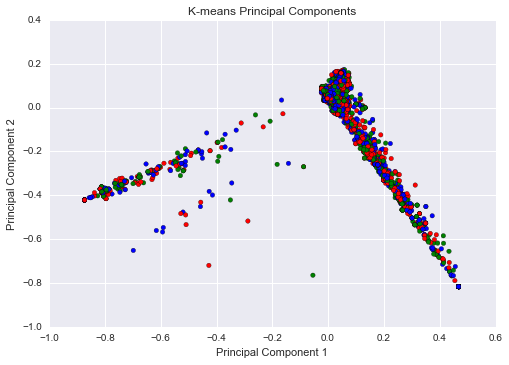

In [8]:
pca(weibo.text)

### Pipeline for LDA

In [ ]:
def lda_pipe(data, n_topics, n_top_words):
    
    n_features = 100
    data_samples = data
    n_topics = n_topics
    n_top_words = n_top_words
    
    

    def print_top_words(model, feature_names, n_top_words):
        terms = []
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
            terms.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
        return terms
        
    def lda_dict(model, feature_names, n_top_words):
        lda_dict = dict()
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            features, rank = [],[]
            features.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
            rank.append(topic[:-n_top_words-1:-1])
            d = dict(zip(features,rank))
            lda_dict[topic_idx] = {k:v for k,v in d.items()}
        return lda_dict

        

#     # Use tf-idf features for NMF.
#     print("Extracting tf-idf features for NMF...")
#     tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=.01) #max_features=n_features

#     tfidf = tfidf_vectorizer.fit_transform(data_samples)

    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01, max_features=n_features)

    tf = tf_vectorizer.fit_transform(data_samples)

#     # Fit the NMF model

#     nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)


#     print("\nTopics in NMF model:")
#     print()
#     print()
#     tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#     print_top_words(nmf, tfidf_feature_names, n_top_words)


    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10,
                                    learning_method='online', learning_offset=50.,
                                    random_state=1)

    lda.fit(tf)


    print("\nTopics in LDA model:")
    print()
    print()
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
    
lda_pipe(weibo.text, 6, 15)

In [ ]:
##modify function for application

def lda_generator(data_samples, n_top_words, n_topics):
    n_features = 100
    data_samples = data_samples
    n_topics = n_topics
    n_top_words = n_top_words
    
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01,ngram_range=(1,2), max_features=n_features)
    
    tf_matrix = tf_vectorizer.fit_transform(data_samples)
    
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10,
                                learning_method='online', learning_offset=50.,
                                random_state=1)
    lda.fit(tf_matrix)
    
    feature_names = tf_vectorizer.get_feature_names()
    
    terms_zh = []

    
    for topic_idx, topic in enumerate(lda.components_):
        lda_topics = (" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
        print(lda_topics)
        terms_zh.append(lda_topics)
        
    return terms_zh


In [ ]:
test = lda_generator(weibo.text, 10, 5)

### LDA Visual

### dataframe of tf-idf matrix

In [ ]:
def vector_df(corpus):
    vectorizer = CountVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(corpus).toarray()
    return pd.DataFrame(X,columns=vectorizer.get_feature_names())
df = vector_df(weibo.text)

### Plot elbows and K-means clusters:

In [ ]:
def plot_kmeans(data):
    tfidf = TfidfVectorizer(min_df=.01, ngram_range=(1,2))
    X = tfidf.fit_transform(data).todense()

    ##### cluster data into K=1..10 clusters #####
    K = range(1,10)

    # scipy kmeans module for each value of k:
    KM = [kmeans(X,k) for k in K]
    ##list comprehension to cluster centroids
    centroids = [cent for (cent,var) in KM]


    # alternative: scipy.spatial.distance.cdist
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    ##### plot ###
    kIdx = 4

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='x', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')

    # scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
    clr = ['b','g','r','c','m','y','k']
    for i in range(K[kIdx]):
        ind = (cIdx[kIdx]==i)
        ax.scatter(X[ind,1],X[ind,2], s=30, c=clr[i], label='Cluster %d'%i)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Censored Tweet Clusters with K=%d' % K[kIdx])
    plt.legend()

plot_kmeans(weibo.text)